In [ ]:
#필요한 라이브러리 불러오기
import requests
from bs4 import BeautifulSoup 
from selenium import webdriver
import re
import time
import pandas as pd
import numpy as np


from collections import Counter
import nltk
import matplotlib.pyplot as plt
from PIL import Image 
from wordcloud import WordCloud, ImageColorGenerator 

%matplotlib inline

## URL 분석

In [ ]:
# url = 'https://search.shopping.naver.com/'+'search/all?query='+'검색하고자 하는 단어'
url = 'https://search.shopping.naver.com/search/all?query=무선+이어폰'

## 상품 기본 정보 추출 - Ask genie any product 함수 생성

In [ ]:
def ask_genie_any_product(product_name):
    
    # Web Scrapping 준비
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')

    driver = webdriver.Chrome(executable_path='(driver) chromedriver.exe',chrome_options=chrome_options)
    url = 'https://shopping.naver.com/'
    driver.get(url)
    
    driver.find_element_by_xpath('//*[@id="autocompleteWrapper"]/input[1]').send_keys(product_name) 
    driver.find_element_by_xpath('//*[@id="autocompleteWrapper"]/a[2]').click()
    url = driver.current_url
    driver.get(url)
    
    # 모든 상품 정보 
    data={}
    names = []  #상품명
    infos = []  #상품 정보(특성)
    like_nums = []  #찜 수
    prices = []  #가격
    url_list = []  #상품 세부 url

    while 1995:
        # 자동 스크롤
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        web_page = BeautifulSoup(driver.page_source, 'html.parser')
        
        # 하나씩 data에서 꺼내오기
        for data in web_page.find_all('div',{'class':'basicList_info_area__17Xyo'}):
            
            try:
                
                #상품이름
                name = data.find('a',{'class':'basicList_link__1MaTN'}).get_text()
                #제품설명
                info = data.find('div',{'class':'basicList_detail_box__3ta3h'}).get_text() 
                info = info.replace(' ','') #제품 설명속 공백제거 
                info = info.replace('|',' ')
                #찜 
                like_num = data.find('em',{'class':'basicList_num__1yXM9'}).get_text()
                like_num = like_num.replace(',','')
                like_num = like_num.strip()
                #가격
                price = data.find('span',{'class':'price_num__2WUXn'}).get_text()
                price = price.replace(',','')
                price = price.replace('원','')
                price= price.strip()
                
                
                #리스트에 각요소 추가
                names.append(name)
                infos.append(info)
                like_nums.append(like_num)
                prices.append(price)

                print('Process {}'.format(name))

            except:

                print('*** 다음 제품의 정보를 크롤링하는 중 에러가 발생했습니다 : {}'.format(name))  
           
        #finding url 
        for find_url in web_page.find_all('a',{'class':'thumbnail_thumb__3Agq6'}):
            try:
            #리스트에 리뷰 추가
                url_list.append(find_url.attrs['href'])
            
            except: print('url error')
            

        #   다음 페이지
        next_page = driver.find_element_by_class_name('pagination_next__1ITTf')
        next_page.click()
        
        # 쉬어주기
        time.sleep(5)

        print('============= Next Page Click ========== ')
        print('')

        # 제품 개수 제한 (100개)
        if(len(names) > 100):
            driver.close()
            driver.quit()
            break
        
        
        
    # DataFrame 생성    
    data_frame_column_name= { "name": names, "price" : prices, "Info" : infos, "like": like_nums, 'url' : url_list}
    product_name_df = pd.DataFrame(data_frame_column_name)
    
    product_name_df =product_name_df[product_name_df.Info != '']
    product_name_df[['price','like']] = product_name_df[['price','like']].astype(int) 

    # 랭킹 순으로 데이터 정렬 후 상품 50개로 cut
    product_name_df = product_name_df.sort_values(by='like', ascending=False)
    product_name_df = product_name_df[:][:50].reset_index()
    product_name_df = product_name_df.drop(['index'], axis=1)
    
    #csv 파일로 저장
    product_name_df.to_csv('{}_df.csv'.format(product_name), index=False)
    
    # ask_genie_any_products 으로 생성된 데이터프레임에서 뽑은 키워드를 genie_show_product_keywords 함수에 적용
    info_dic = genie_show_product_keywords(product_name_df)

    # info_dic으로 워드클라우드 생성
    return genie_make_wordcloud(info_dic, color)

### (Collab 에서 실행하는 경우)

In [ ]:
# def ask_genie_any_product(product_name):
    
#     chrome_options = webdriver.ChromeOptions()
#     chrome_options.add_argument('--headless')
#     chrome_options.add_argument('--no-sandbox')
#     chrome_options.add_argument('--disable-dev-shm-usage')
#     wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
#     driver =webdriver.Chrome('chromedriver',chrome_options=chrome_options)
#     url = 'https://shopping.naver.com/'
#     driver.get(url)
    
#     driver.find_element_by_xpath('//*[@id="autocompleteWrapper"]/input[1]').send_keys(product_name) # (영화이름 + 년도)로 검색
#     driver.find_element_by_xpath('//*[@id="autocompleteWrapper"]/a[2]').click()
#     url = driver.current_url
#     driver.get(url)
#     # 모든 상품 정보 
#     data={}
#     names = []
#     infos = []
#     like_nums = []
#     prices = []
    
#     url_list = []

#     while 1995:
        
        
#         driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        
#         web_page = BeautifulSoup(driver.page_source, 'html.parser')
#         #finding url 
#         for find_url in web_page.find_all('a',{'class':'thumbnail_thumb__3Agq6'}):
#             try:
#                 #리스트에 리뷰 추가
#                 url_list.append(find_url.attrs['href'])
#             except: print('url error')
        
#         for data in web_page.find_all('div',{'class':'basicList_info_area__17Xyo'}):
            
#         # 하나씩 data에서 꺼내오기
#             try:
                
#                 #상품이름
#                 name = data.find('a',{'class':'basicList_link__1MaTN'}).get_text()
#                 #제품설명
#                 info = data.find('div',{'class':'basicList_detail_box__3ta3h'}).get_text() 
#                 info = info.replace(' ','') #제품 설명속 공백제거 
#                 info = info.replace('|',' ')
#                 #찜 
#                 like_num = data.find('em',{'class':'basicList_num__1yXM9'}).get_text()
#                 like_num = like_num.replace(',','')
#                 like_num = like_num.strip()
#                 #가격
#                 price = data.find('span',{'class':'price_num__2WUXn'}).get_text()
#                 price = price.replace(',','')
#                 price = price.replace('원','')
#                 price= price.strip()
                
                
#                 #리스트에 각요소 추가
#                 names.append(name)
#                 infos.append(info)
#                 like_nums.append(like_num)
#                 prices.append(price)


#                 print('Process {}'.format(name))

#             except:

#                 print('*** 다음 제품의 정보를 크롤링하는 중 에러가 발생했습니다 : {}'.format(name))  
                
                
          
            

#         #   driver.find_element_by_class_name('pagination_next__1ITTf').click()
#         next_page = driver.find_element_by_class_name('pagination_next__1ITTf')
#         next_page.click()

#         time.sleep(5)

#         print('============= Next Page Click ========== ')
#         print('')

#         # 제품 개수 제한
#         if(len(names) > 100):
#             driver.close()
#             driver.quit()
#             break
        
        
        
        
        
        
#     data_frame_column_name= { "name": names, "price" : prices, "Info" : infos, "like": like_nums, 'url' : url_list}
#     product_name_df = pd.DataFrame(data_frame_column_name)

#     product_name_df =product_name_df[product_name_df.Info != '']
#     product_name_df[['price','like']] = product_name_df[['price','like']].astype(int) 


#     product_name_df = product_name_df.sort_values(by='like', ascending=False)
#     product_name_df = product_name_df[:][:50].reset_index()
#     product_name_df = product_name_df.drop(['index'], axis=1)
    

#     product_name_df.to_csv('{}_df.csv'.format(product_name), index=False)

#     info_dic = genie_show_product_keywords(product_name_df)
# #     genie_make_wordcloud(info_dic, color)
    
#     return genie_make_wordcloud(info_dic, color)

## 상품군 키워드 추출 - Genie show product keywords 함수 생성

In [ ]:
def genie_show_product_keywords(df):
#-----------
    # 문자열로 like기준으로 정렬하게 되면 1 10 2 30 이런 식으로 잘못 정렬하게됨 int로 고쳐주기
    product_info = df['Info'].tolist()

    # 기호 제거
    for i in range(len(product_info)):
        product_info[i] = re.sub(r'[^\w\s]',' ',product_info[i])

    # 워드 클라우드 용 키워드 뭉치
    info = []
    info_dic = {}
    

    for item in product_info:
        for word in item.split(' '):
            if(word != ''):
                info.append(word)

    for word in info:
        if word not in info_dic:
            info_dic[word] = 1
        else:
            info_dic[word] += 1
            
    new_info_dic = {key : value for key, value in info_dic.items() if value > 10}
    
    return new_info_dic 

## 상품군 키워드 Wordcloud - Genie make wordcloud 함수 생성

In [ ]:
def genie_make_wordcloud(info_dic, color) :
    # Naver shopping logo 로 mark 입히기
    lamp_mark = np.array(Image.open("lamp.jpg"))
    
    #글씨체 ELAND 나이스 초이스체 적용
    function_cloud= WordCloud(font_path="C:/Users/LG/Desktop/ELAND_M.ttf",
                     width=2000, height=1000,
                     max_words=50, # 단어 50개만 표시
                     mask=lamp_mark,
                     background_color='black',
                     colormap = '{}'.format(color))
                     
    
    function_cloud.generate_from_frequencies(info_dic) 

    plt.figure(figsize=(13,13))
    plt.imshow(function_cloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig('{}_keyword_wordcloud.png'.format(product_name))
    plt.show()

## 입력값 받기 (Test)

지니에게 검색을 부탁하세요 :아이패드
지니에게 원하는 글자색을 말해주세요 (Blues, Reds, Greens, Oranges, Purples) : Reds
Process Apple 아이패드 에어 4세대 WIFI 64G
Process Apple 아이패드 에어 4세대 WIFI 256G
Process Apple 아이패드 8세대 WIFI 128G
Process Apple 아이패드 프로 4세대 12.9형 WIFI 128G
Process Apple 아이패드 미니 5세대 WIFI 64G
Process Apple 아이패드 8세대 WIFI 32G
Process Apple 아이패드 프로 4세대 12.9형 WIFI 256G
Process Apple 아이패드 프로 3세대 11 WiFi 64G
Process Apple 아이패드 에어 3세대 WIFI 64G
Process Apple 아이패드 7세대 WIFI 32G
Process Apple 아이패드 프로 2세대 11형 WIFI 256G
Process Apple 아이패드 9.7 (2018) 6세대 WiFi 32G
Process Apple 아이패드 미니 5세대 WIFI 256G
Process Apple 아이패드 프로 2세대 11형 WIFI 128G
Process Apple 아이패드 7세대 WIFI 128G
Process Apple 아이패드 9.7 (2018) 6세대 WiFi 128GB
Process Apple 아이패드 프로 4세대 11 WiFi 256G
Process Apple 아이패드 프로 4세대 12.9형 WIFI 512G
Process Apple 아이패드 프로 2세대 10.5 (2017) WiFi 256GB
Process Apple 아이패드 에어 3세대 WIFI 256G
Process Apple 아이패드 미니 5세대 WIFI + 셀룰러 64G
Process Apple 아이패드 프로 3세대 11 WiFi 256G
Process Apple 아이패드 프로 3세대 12.9 WiFi 256G
Process Apple 아이패드 9.7 (2017

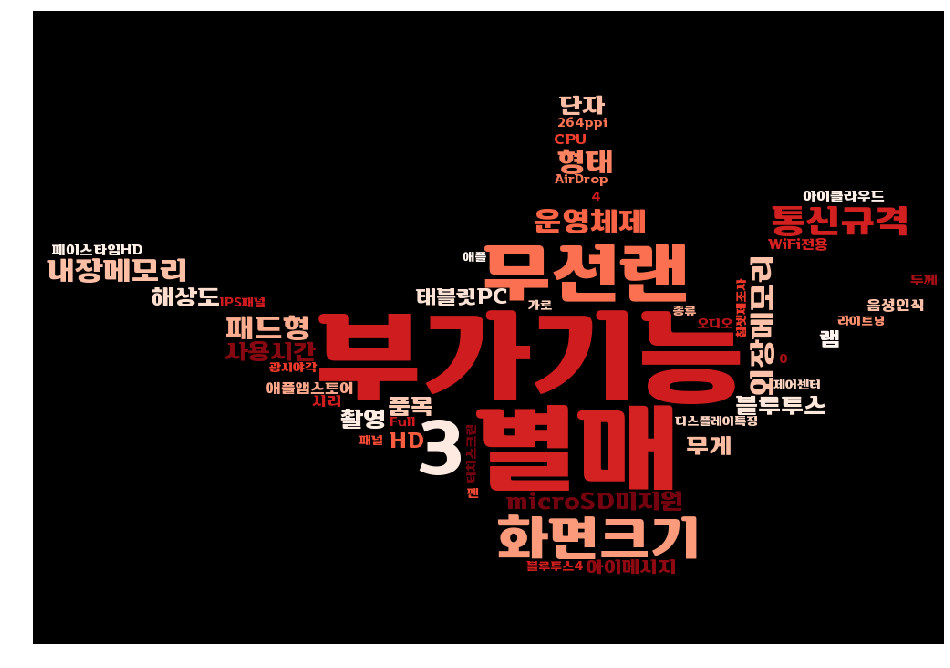

In [ ]:
product_name = input('지니에게 검색을 부탁하세요 :')
#matplotblib 색상표에 있는 색으로 선택지 좁혀주기
color = input('지니에게 원하는 글자색을 말해주세요 (Blues, Reds, Greens, Oranges, Purples) : ')
ask_genie_any_product(product_name) 

# 상품 리뷰 Scrapping

In [ ]:
# ask genie any product 로 생성된 '검색상품_df.csv' 파일 불러오기
product_df = pd.read_csv('아이패드_df.csv',encoding = 'utf-8')

In [ ]:
product_df.head()

,name,price,Info,like,url
0,Apple 아이패드 9.7 (2018) 6세대 WiFi 32G,594150,화면크기:9.7인치(24.6cm) 통신규격:WiFi전용 내장메모리:32GB 형태:패...,2269,https://cr.shopping.naver.com/adcr.nhn?x=tVRNS...
1,Apple 아이패드 9.7 (2018) 6세대 WiFi 128GB,661040,화면크기:9.7인치(24.6cm) 통신규격:WiFi전용 내장메모리:128GB 램:2...,2004,https://cr.shopping.naver.com/adcr.nhn?x=olYBY...
2,Apple 아이패드 미니 5세대 WIFI 64G,474290,화면크기:7.9인치(19.9cm) 통신규격:WiFi전용 내장메모리:64GB 램:3G...,1512,https://cr.shopping.naver.com/adcr.nhn?x=8AvCs...
3,Apple 아이패드 에어 3세대 WIFI 64G,798820,화면크기:10.5인치(26.7cm) 통신규격:WiFi전용 내장메모리:64GB 램:3...,1346,https://cr.shopping.naver.com/adcr.nhn?x=xs543...
4,Apple 아이패드 에어 4세대 WIFI 64G,726540,화면크기:10.9인치(27.6cm) 통신규격:WiFi전용 내장메모리:64GB 램:4...,1222,https://cr.shopping.naver.com/adcr.nhn?x=IqKFm...


In [ ]:
# from selenium.webdriver.chrome.options import Options
# options = Options()
# options.binary_location = "C:\Program Files (x86)\Google\Chrome\Application" # 실제 크롬 브라우저 설치 경로를 찾아 적용
# driver = webdriver.Chrome(executable_path='(driver) chromedriver.exe') # webdriver 실행 시마다 동일
# review_total = []
# # review = []

# for url in df['url'][:10] :
#     try:
#         driver.get(url)
#         web_page = BeautifulSoup(driver.page_source, 'html.parser')
    
#     except:
#             print('*** 다음 url 접속중 에러가 발생했습니다 : {}'.format(url))
#     review = []
#     for data in web_page.find_all('span',{'class':'totalArea_text__2A3ow'}):
        
#         try:
#             review.append(data.get_text())
#             print('Process : {}'.format(data.attrs['href']))
            
            

#         except:
#             print('*** 다음 제품의 정보를 크롤링하는 중 에러가 발생했습니다 : {}'.format(data.get_text()))
#     word = ''.join(review)
#     review_total.append(word) #리스트에 리뷰 추가
#     time.sleep(5)
#     print('============= another page ========== ')
# # df['N_review']  = review_total 
# print('The list is added to review')
# driver.close()
# driver.quit()    

In [ ]:
# 각 리뷰(url)에서 첫번째 리뷰본문.get_text()
review = []
for web_url in product_df['url']:
    
    headers = {'User-Agent':'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36'}
    web = requests.get(web_url,headers=headers).content
    product_web_page = BeautifulSoup(web, 'html.parser')
    
    try:
            article = product_web_page.find('p',{'class':'reviewItems_text__XIsTc'})
            review.append(article.get_text())
            
    
    except:
            print('pass')

pass


In [ ]:
# 유사도 분석을 위해 csv 파일로 저장해두기
review_pd = pd.DataFrame(review)
review_pd.to_csv('{}_review.txt'.format(product_name))
        

In [ ]:
# review의 각 text를 하나로 합치기
articles = ' '.join(review)

In [ ]:
# Knolpy 오류 방지를 위해 이모티콘 제거
emoji = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
text_refine = emoji.sub(r'', articles)

# 총 길이 확인
len(text_refine)

15473

## 단어 정규화 및 어근화, 품사 태깅

In [ ]:
from konlpy.tag import Okt

twitter = Okt()
raw_pos_tagged = twitter.pos(text_refine, norm=True, stem=True) # POS Tagging
print(raw_pos_tagged)

[('자다', 'Verb'), ('받다', 'Verb'), ('.', 'Punctuation'), ('일이', 'Noun'), ('있다', 'Adjective'), ('접속', 'Noun'), ('이', 'Josa'), ('늦다', 'Verb'), ('이제야', 'Noun'), ('구', 'Modifier'), ('매', 'Modifier'), ('결정', 'Noun'), ('을', 'Josa'), ('하다', 'Verb'), ('.', 'Punctuation'), ('애플', 'Noun'), ('코리아', 'Noun'), ('제품', 'Noun'), ('이니', 'Josa'), ('초기', 'Noun'), ('불량', 'Noun'), ('만', 'Josa'), ('확인', 'Noun'), ('하다', 'Verb'), ('되다', 'Verb'), ('터', 'Noun'), ('라', 'Josa'), ('바로', 'Noun'), ('해드리다', 'Verb'), ('하다', 'Verb'), ('(_', 'Punctuation'), ('_)', 'Punctuation'), ('개인', 'Noun'), ('적', 'Suffix'), ('으로', 'Josa'), ('병원', 'Noun'), ('도', 'Josa'), ('다니다', 'Verb'), ('일이', 'Noun'), ('갑자기', 'Noun'), ('생기', 'Noun'), ('고', 'Josa'), (',', 'Punctuation'), ('개봉', 'Noun'), ('도', 'Josa'), ('늦어지다', 'Verb'), ('하다', 'Verb'), ('이제야', 'Noun'), ('ㅎㅎ', 'KoreanParticle'), ('일단', 'Noun'), ('알다', 'Verb'), (',', 'Punctuation'), ('펜', 'Noun'), ('도', 'Josa'), ('되다', 'Verb'), ('6', 'Number'), ('세대', 'Noun'), ('보급', 'Noun'), ('형', 'Suff

## 단어 등장 빈도 count

In [ ]:
common_list = ['하다', '있다', '되다', '이다', '돼다','매우', '않다','들다','정도','되어다','해보다','써다','쓰다','보다','자다','받다', '없다', '그렇다', '아니다', '이렇다', '그렇다', '어떻다', '광고', '크리스마스', '같다'] 
stopwords_df = pd.read_json('stopwords-ko.json')
stopwords= stopwords_df[0].tolist()
word_cleaned = []
del_list = common_list + stopwords


for word in raw_pos_tagged: 
    
    if word[1] not in ["Josa", "Eomi", "Punctuation", "Foreign"]: 
        if (len(word[0]) != 1) & (word[0] not in del_list): 
            word_cleaned.append(word[0])

print(word_cleaned)

['일이', '접속', '늦다', '이제야', '결정', '애플', '코리아', '제품', '초기', '불량', '확인', '바로', '해드리다', '개인', '병원', '다니다', '일이', '갑자기', '생기', '개봉', '늦어지다', '이제야', 'ㅎㅎ', '일단', '알다', '세대', '보급', '패드', '요즘', '패드', '아무래도', '패드', '류론', '아이패드', '가장', '나가다', '이번', '세대', '보급', '가격', '애플', '유저', '가장', '싶다', '프로', '애플', '쓸다', '좋다', '패드', '필요없다', '일단', '띄다', '초기', '불량', '보이지', '문제', '애플스토어', '문의', '부분', '잘쓰다', '실버', '세대', '이번', '블랙', '구매', '해봤다', '화이트', '화이트', '블랙', '블랙', '매력', '상품', '일단', '안전', '포장', '추가', '뽁뽁이', '많이', '감겨', '서다', '문제', '없이', '작동', '문제', '없이', '그래도', '90일', '한번', '주의', '깊다', '근데', '세대', '충전기', '다르다', '충전기', '한자', '적히다', '어디서', '제조', '따르다', '다른', '가보다', '터치', '칼라', '이용', '횟수', '잦다', '애플', '펜슬', '구매', '배송', '새벽', '주문', '바로', '발송', '다음', '만족하다', '스마트', '커버', '추가', '회전', '살걸', '후회', '생각', '얇다', '약하다', '지지', '대가', '한쪽', '사용', '가능하다', '불편하다', 'ㅜㅜ', '강화', '필름', '밀대', '붙이다', '너무', '힘들다', '그래서', '실패하다', '결국', '오프라인', '재다', '부착', '추가', '지출', '아쉽다', '부분', '부주의', '밀대', '상품', '좋다', '번창', '아이패드', '미니', '굉장하다', '오

In [ ]:
#단어 수 count를 위해 단어 dict 생성
word_dic = {}

for word in word_cleaned:
    if word not in word_dic:
        word_dic[word] = 1 # changed from "0" to "1"
    else:
        word_dic[word] += 1

In [ ]:
# 단어 빈도 count
from collections import Counter

result = Counter(word_cleaned)
word_dic = dict(result)

print(word_dic)

{'일이': 3, '접속': 2, '늦다': 5, '이제야': 2, '결정': 6, '애플': 28, '코리아': 2, '제품': 29, '초기': 3, '불량': 7, '확인': 8, '바로': 17, '해드리다': 1, '개인': 2, '병원': 1, '다니다': 5, '갑자기': 1, '생기': 1, '개봉': 2, '늦어지다': 1, 'ㅎㅎ': 7, '일단': 8, '알다': 6, '세대': 16, '보급': 2, '패드': 15, '요즘': 4, '아무래도': 1, '류론': 1, '아이패드': 38, '가장': 4, '나가다': 2, '이번': 8, '가격': 19, '유저': 2, '싶다': 11, '프로': 17, '쓸다': 5, '좋다': 47, '필요없다': 1, '띄다': 2, '보이지': 1, '문제': 6, '애플스토어': 2, '문의': 4, '부분': 8, '잘쓰다': 3, '실버': 8, '블랙': 3, '구매': 33, '해봤다': 3, '화이트': 2, '매력': 1, '상품': 8, '안전': 1, '포장': 15, '추가': 7, '뽁뽁이': 5, '많이': 10, '감겨': 2, '서다': 6, '없이': 13, '작동': 6, '그래도': 8, '90일': 1, '한번': 4, '주의': 2, '깊다': 1, '근데': 12, '충전기': 8, '다르다': 4, '한자': 1, '적히다': 2, '어디서': 1, '제조': 1, '따르다': 2, '다른': 8, '가보다': 1, '터치': 5, '칼라': 1, '이용': 1, '횟수': 1, '잦다': 1, '펜슬': 14, '배송': 21, '새벽': 1, '주문': 20, '발송': 5, '다음': 5, '만족하다': 14, '스마트': 1, '커버': 2, '회전': 1, '살걸': 1, '후회': 5, '생각': 17, '얇다': 2, '약하다': 1, '지지': 1, '대가': 1, '한쪽': 1, '사용': 35, '가능하다': 3, '불편하다': 2, 'ㅜㅜ

In [ ]:
# 빈도가 높은 순으로 단어 정렬
sorted_word_dic = sorted(word_dic.items(), key=lambda x:x[1], reverse=True)
print(sorted_word_dic)

[('좋다', 47), ('아이패드', 38), ('사용', 35), ('너무', 35), ('구매', 33), ('제품', 29), ('애플', 28), ('배송', 21), ('주문', 20), ('오다', 20), ('사다', 20), ('가격', 19), ('바로', 17), ('프로', 17), ('생각', 17), ('세대', 16), ('필름', 16), ('해주다', 16), ('패드', 15), ('포장', 15), ('고민', 15), ('에어', 15), ('정말', 15), ('펜슬', 14), ('만족하다', 14), ('미니', 14), ('때문', 14), ('없이', 13), ('근데', 12), ('구입', 12), ('모르다', 12), ('후기', 12), ('싶다', 11), ('주다', 11), ('화면', 11), ('많이', 10), ('안되다', 10), ('가다', 10), ('그리고', 10), ('색상', 10), ('충전', 9), ('이상', 9), ('교환', 9), ('처음', 9), ('판매', 9), ('확인', 8), ('일단', 8), ('이번', 8), ('부분', 8), ('실버', 8), ('상품', 8), ('그래도', 8), ('충전기', 8), ('다른', 8), ('선택', 8), ('기능', 8), ('걸리다', 8), ('선물', 8), ('기다리다', 8), ('서비스', 8), ('케이스', 8), ('물건', 8), ('불량', 7), ('ㅎㅎ', 7), ('추가', 7), ('아쉽다', 7), ('지원', 7), ('살다', 7), ('추천', 7), ('조금', 7), ('그냥', 7), ('가지', 7), ('크다', 7), ('드리다', 7), ('나오다', 7), ('빠르다', 7), ('박스', 7), ('지인', 7), ('걱정', 7), ('결정', 6), ('알다', 6), ('문제', 6), ('서다', 6), ('작동', 6), ('붙이다', 6), ('그래

### 선 그래프, 막대 그래프로 시각화

In [ ]:
import nltk
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_name = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name() 
matplotlib.rc('font', family=font_name)

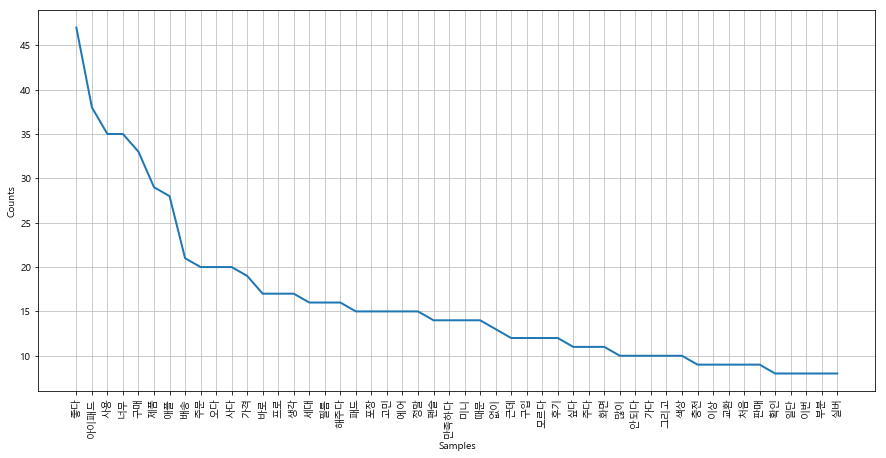

In [ ]:
# nltk 로 단어 빈도수 더 쉽게 count 해보기
word_counted = nltk.Text(word_cleaned) 
plt.figure(figsize=(15, 7)) # plot 영역(그래프 영역)의 크기를 지정합니다.
word_counted.plot(50)

In [ ]:
# dict 를 데이터프레임으로 가져오기
df = pd.DataFrame(list(word_dic.values()), word_dic.keys()) 

result= df.sort_values([0], ascending=False)
result_cut = result[:50]
result_cut.tail(3)

,0
상품,8
다른,8
그래도,8


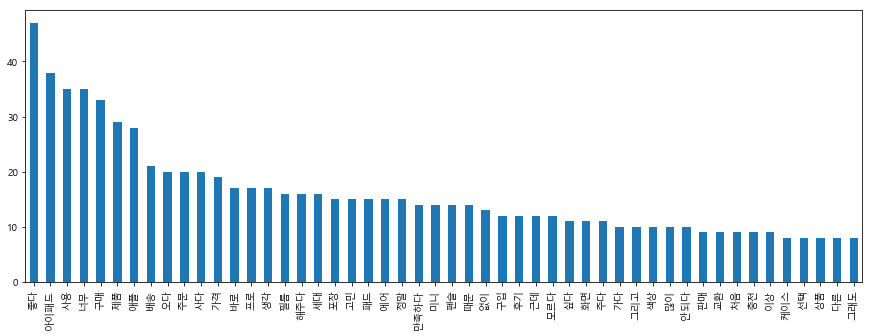

In [ ]:
result_cut.plot(kind='bar', legend=False, figsize=(15, 5))
plt.show()

In [ ]:
# from wordcloud import WordCloud
# from PIL import Image # 만약 "No module named 'PIL'" 에러가 발생하면 [ pip install Pillow==5.4.1 ] 로 라이브러리를 설치해줍니다.

# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline

## 리뷰 Wordcloud 생성

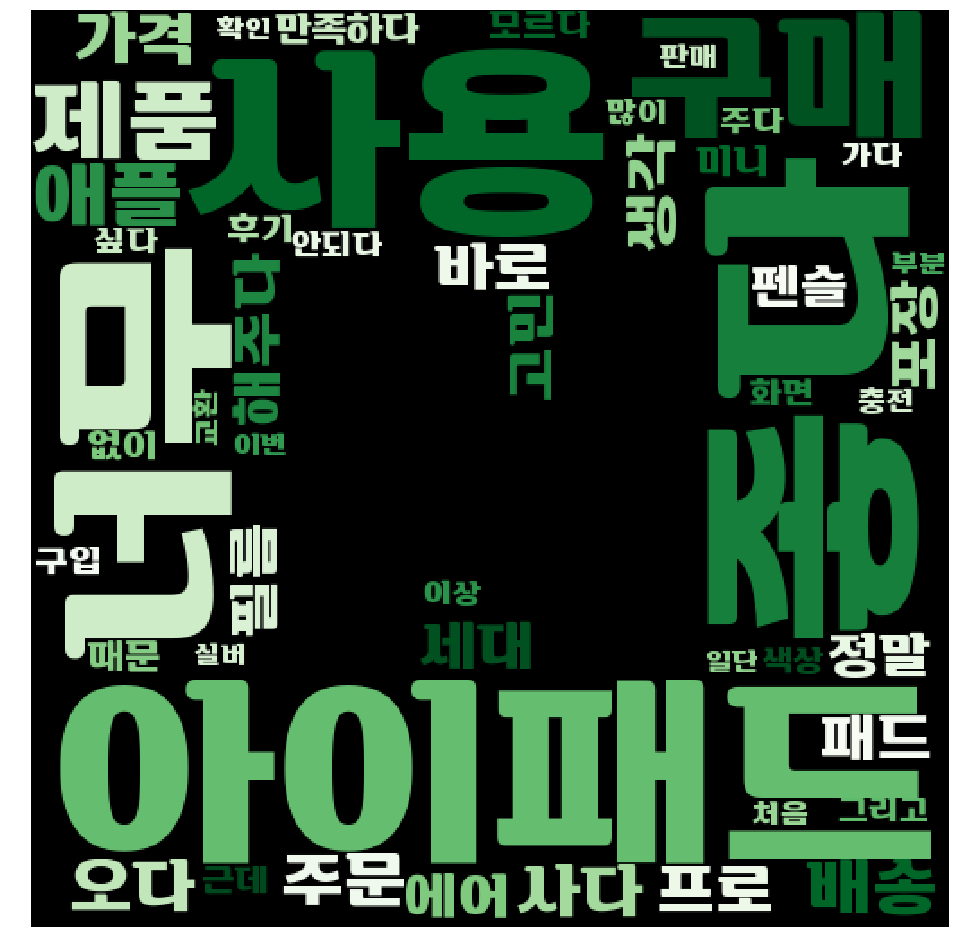

In [ ]:
review_logo = np.array(Image.open("naver.png"))

function_cloud= WordCloud(font_path="C:/Users/LG/Desktop/ELAND_M.ttf",
                     width=2000, height=1000,
                     max_words=50, # 단어 70개만 표시
                     mask=review_logo,
                     background_color='black', 
                     colormap = 'Greens')

function_cloud.generate_from_frequencies(word_dic) 

plt.figure(figsize=(13,13))
plt.imshow(function_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
#     plt.savefig('{}_keyword_wordcloud.png'.format(product_name))
plt.show()

# 동일 상품군의 서로 다른 두 제품 리뷰 유사도 분석

In [ ]:
def measure_similarity(csv_file_name1,csv_file_name2) :
    

    import numpy as np
    from sklearn import linear_model 
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity 
    
    df_1= pd.read_csv(csv_file_name1,index_col= [0])
    df_2 = pd.read_csv(csv_file_name2,index_col= [0])
    
    doc1 = df_1.to_string()
    doc2 = df_2.to_string()
    
    
    corpus = [doc1, doc2]  # doc1, doc2를 합쳐 corpus list를 생성
    
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus).todense()
    
    return print("Similarity between two products : ", cosine_similarity(X[0], X[1]) )
    

In [ ]:
measure_similarity('아이패드_review.txt','갤럭시탭_review.txt' )

Similarity between two products :  [[0.11500565]]
